In [1]:
!nvidia-smi

Thu Jul 15 16:07:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    38W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
moving_average_window = 7

In [4]:
total_df = pd.read_csv('./total.csv').drop('Unnamed: 0', axis=1)

In [5]:
for idx, country in enumerate(list(set(total_df['CountryCode']))):
    total_df.loc[total_df['CountryCode'] == country,'covid_confirmed'] = \
        total_df.loc[total_df['CountryCode'] == country,'covid_confirmed'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'covid_deaths'] = \
        total_df.loc[total_df['CountryCode'] == country,'covid_deaths'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'covid_recovered'] = \
        total_df.loc[total_df['CountryCode'] == country,'covid_recovered'].rolling(window=moving_average_window).mean()
    
    total_df.loc[total_df['CountryCode'] == country,'test_cumulTotal'] = \
        total_df.loc[total_df['CountryCode'] == country,'test_cumulTotal'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'test_7dayMA'] = \
        total_df.loc[total_df['CountryCode'] == country,'test_7dayMA'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'test_shortPosRate'] = \
        total_df.loc[total_df['CountryCode'] == country,'test_shortPosRate'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'test_shortTestperCase'] = \
        total_df.loc[total_df['CountryCode'] == country,'test_shortTestperCase'].rolling(window=moving_average_window).mean()
    
    total_df.loc[total_df['CountryCode'] == country,'vac_first'] = \
        total_df.loc[total_df['CountryCode'] == country,'vac_first'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'vac_second'] = \
        total_df.loc[total_df['CountryCode'] == country,'vac_second'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'vac_daily'] = \
        total_df.loc[total_df['CountryCode'] == country,'vac_daily'].rolling(window=moving_average_window).mean()
    
    total_df.loc[total_df['CountryCode'] == country,'mob_retailRecreation'] = \
        total_df.loc[total_df['CountryCode'] == country,'mob_retailRecreation'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'mob_groceryPharmacy'] = \
        total_df.loc[total_df['CountryCode'] == country,'mob_groceryPharmacy'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'mob_parks'] = \
        total_df.loc[total_df['CountryCode'] == country,'mob_parks'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'mob_transit'] = \
        total_df.loc[total_df['CountryCode'] == country,'mob_transit'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'mob_work'] = \
        total_df.loc[total_df['CountryCode'] == country,'mob_work'].rolling(window=moving_average_window).mean()
    total_df.loc[total_df['CountryCode'] == country,'mob_resident'] = \
        total_df.loc[total_df['CountryCode'] == country,'mob_resident'].rolling(window=moving_average_window).mean()
    

In [6]:
total_df.dropna(inplace=True)
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52452 entries, 6 to 53027
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CountryCode            52452 non-null  object 
 1   date                   52452 non-null  object 
 2   covid_confirmed        52452 non-null  float64
 3   covid_deaths           52452 non-null  float64
 4   covid_recovered        52452 non-null  float64
 5   test_cumulTotal        52452 non-null  float64
 6   test_7dayMA            52452 non-null  float64
 7   test_shortPosRate      52452 non-null  float64
 8   test_shortTestperCase  52452 non-null  float64
 9   vac_first              52452 non-null  float64
 10  vac_second             52452 non-null  float64
 11  vac_daily              52452 non-null  float64
 12  mob_retailRecreation   52452 non-null  float64
 13  mob_groceryPharmacy    52452 non-null  float64
 14  mob_parks              52452 non-null  float64
 15  mo

In [7]:
# prepare dataset
window = 56
predict = 28

data_x = list()
data_y = list()



for idx, country in enumerate(list(set(total_df['CountryCode']))):
    cur_df = total_df[total_df['CountryCode'] == country]
    print('.', end='')
    
    time_range = sorted(set(cur_df['date']))
    for time_idx in range(len(time_range)-(window+predict) + 1):
        view_start_date = time_range[time_idx]
        view_end_date = time_range[time_idx+(window-1)]
        
        pred_start_date = time_range[time_idx+window]
        pred_end_date = time_range[time_idx+(window+predict-1)]
        
        data = cur_df[(view_start_date <= cur_df['date']) & (cur_df['date'] <= pred_end_date)][[
            'covid_confirmed',
            'covid_deaths',
            'covid_recovered',
            'test_cumulTotal',
            'test_7dayMA',
            'test_shortPosRate',
            'test_shortTestperCase',
            'vac_first',
            'vac_second',
            'vac_daily',
            'mob_retailRecreation',
            'mob_groceryPharmacy',
            'mob_parks',
            'mob_transit',
            'mob_work',
            'mob_resident',
        ]]
        
        normalised_data = list()
        for feature in [
            'covid_confirmed',
            'covid_deaths',
            'covid_recovered',
            'test_cumulTotal',
            'test_7dayMA',
            'test_shortPosRate',
            'test_shortTestperCase',
            'vac_first',
            'vac_second',
            'vac_daily',
            'mob_retailRecreation',
            'mob_groceryPharmacy',
            'mob_parks',
            'mob_transit',
            'mob_work',
            'mob_resident',
        ]:
            scaler = preprocessing.StandardScaler().fit(data[feature].to_numpy().reshape(-1, 1))
            scaled_data = scaler.transform(data[feature].to_numpy().reshape(-1, 1))
            normalised_data.append(scaled_data.reshape(1, -1)[0])

        normalised_data = np.transpose(np.array(normalised_data))

        x = np.array(normalised_data[:window, :])
        y = np.array(normalised_data[window:window+predict, 0])

        data_x.append(x)
        data_y.append(y)    


................................................................................................

In [29]:
# (data size, time_steps, features)

np_x = np.array(data_x)
np_y = np.array(data_y)
print(np_x.shape)
print(np_y.shape)

(43270, 56, 16)
(43270, 28)


In [32]:
x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size=0.1, shuffle=True, random_state=42)
# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, random_state=42)

In [33]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(38943, 56, 16) (4327, 56, 16)
(38943, 28) (4327, 28)


# Modelling

In [34]:
batch_size = 512

In [ ]:
import keras.backend as K

def sMAPE(y_true, y_pred):
    diff_df = K.abs(y_true - y_pred)
    sum_abs_df = K.abs(y_true) + K.abs(y_pred)

    return K.round((100 - (diff_df / sum_abs_df) * 100)*100)/100

In [101]:
model = keras.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=7, padding='SAME', input_shape=(window, 16)))
# model.add(layers.Conv1D(filters=32, kernel_size=14, padding='SAME'))
model.add(layers.Conv1D(filters=64, kernel_size=7, padding='SAME'))
# model.add(layers.Conv1D(filters=64, kernel_size=14, padding='SAME'))

model.add(layers.LSTM(units=32, activation='tanh', return_sequences=True))
model.add(layers.LSTM(units=64, activation='tanh', return_sequences=True))
model.add(layers.LSTM(units=128, activation='tanh', return_sequences=True))
model.add(layers.LSTM(units=256, activation='tanh', return_sequences=False))
model.add(layers.LSTM(units=512, activation='tanh', return_sequences=False))

model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(128))

model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(64))

model.add(layers.Dense(predict))

model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 56, 32)            3616      
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 56, 64)            14400     
_________________________________________________________________
lstm_24 (LSTM)               (None, 56, 32)            12416     
_________________________________________________________________
lstm_25 (LSTM)               (None, 56, 64)            24832     
_________________________________________________________________
lstm_26 (LSTM)               (None, 56, 128)           98816     
_________________________________________________________________
lstm_27 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)             

In [102]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습과정 설정 
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse', sMAPE])

# 모델 트레이닝 
history = model.fit(x_train, y_train, validation_split=0.1, 
                     epochs=300, batch_size=batch_size, callbacks=[early_stopping], verbose=1)

Epoch 1/300
69/69 [==============================] - 9s 68ms/step - loss: 0.6506 - acc: 0.1356 - mae: 0.6048 - mse: 0.6506 - sMAPE: 50.5172 - val_loss: 0.2964 - val_acc: 0.3949 - val_mae: 0.3791 - val_mse: 0.2964 - val_sMAPE: 69.4164
Epoch 2/300
69/69 [==============================] - 3s 50ms/step - loss: 0.2949 - acc: 0.2648 - mae: 0.3786 - mse: 0.2949 - sMAPE: 69.6908 - val_loss: 0.2430 - val_acc: 0.3974 - val_mae: 0.3240 - val_mse: 0.2430 - val_sMAPE: 73.5792
Epoch 3/300
69/69 [==============================] - 3s 50ms/step - loss: 0.2508 - acc: 0.2892 - mae: 0.3411 - mse: 0.2508 - sMAPE: 72.2038 - val_loss: 0.2323 - val_acc: 0.4072 - val_mae: 0.3187 - val_mse: 0.2323 - val_sMAPE: 73.0760
Epoch 4/300
69/69 [==============================] - 3s 50ms/step - loss: 0.2357 - acc: 0.3084 - mae: 0.3292 - mse: 0.2357 - sMAPE: 72.9039 - val_loss: 0.2075 - val_acc: 0.4064 - val_mae: 0.2968 - val_mse: 0.2075 - val_sMAPE: 74.9919
Epoch 5/300
69/69 [==============================] - 4s 52ms/ste

Epoch 36/300
69/69 [==============================] - 3s 50ms/step - loss: 0.0632 - acc: 0.4360 - mae: 0.1788 - mse: 0.0632 - sMAPE: 82.8182 - val_loss: 0.0578 - val_acc: 0.4578 - val_mae: 0.1650 - val_mse: 0.0578 - val_sMAPE: 83.9281
Epoch 37/300
69/69 [==============================] - 3s 50ms/step - loss: 0.0632 - acc: 0.4300 - mae: 0.1788 - mse: 0.0632 - sMAPE: 82.8424 - val_loss: 0.0513 - val_acc: 0.4624 - val_mae: 0.1567 - val_mse: 0.0513 - val_sMAPE: 84.3826
Epoch 38/300
69/69 [==============================] - 3s 51ms/step - loss: 0.0599 - acc: 0.4347 - mae: 0.1745 - mse: 0.0599 - sMAPE: 83.2165 - val_loss: 0.0511 - val_acc: 0.4765 - val_mae: 0.1533 - val_mse: 0.0511 - val_sMAPE: 84.6711
Epoch 39/300
69/69 [==============================] - 3s 51ms/step - loss: 0.0598 - acc: 0.4374 - mae: 0.1733 - mse: 0.0598 - sMAPE: 83.2112 - val_loss: 0.0497 - val_acc: 0.4739 - val_mae: 0.1516 - val_mse: 0.0497 - val_sMAPE: 84.8540
Epoch 40/300
69/69 [==============================] - 3s 50m

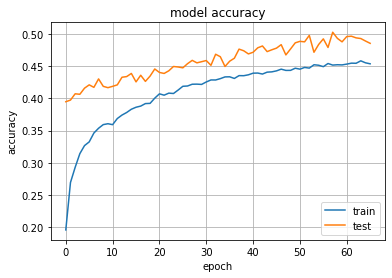

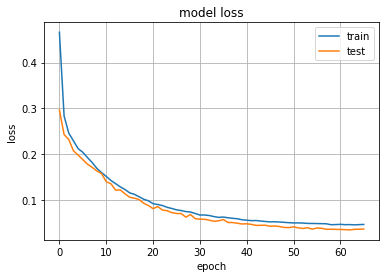

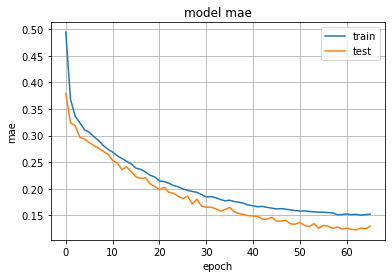

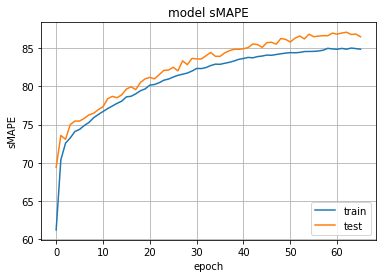

In [104]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.grid()
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for sMAPE
plt.plot(history.history['sMAPE'])
plt.plot(history.history['val_sMAPE'])
plt.grid()
plt.title('model sMAPE')
plt.ylabel('sMAPE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

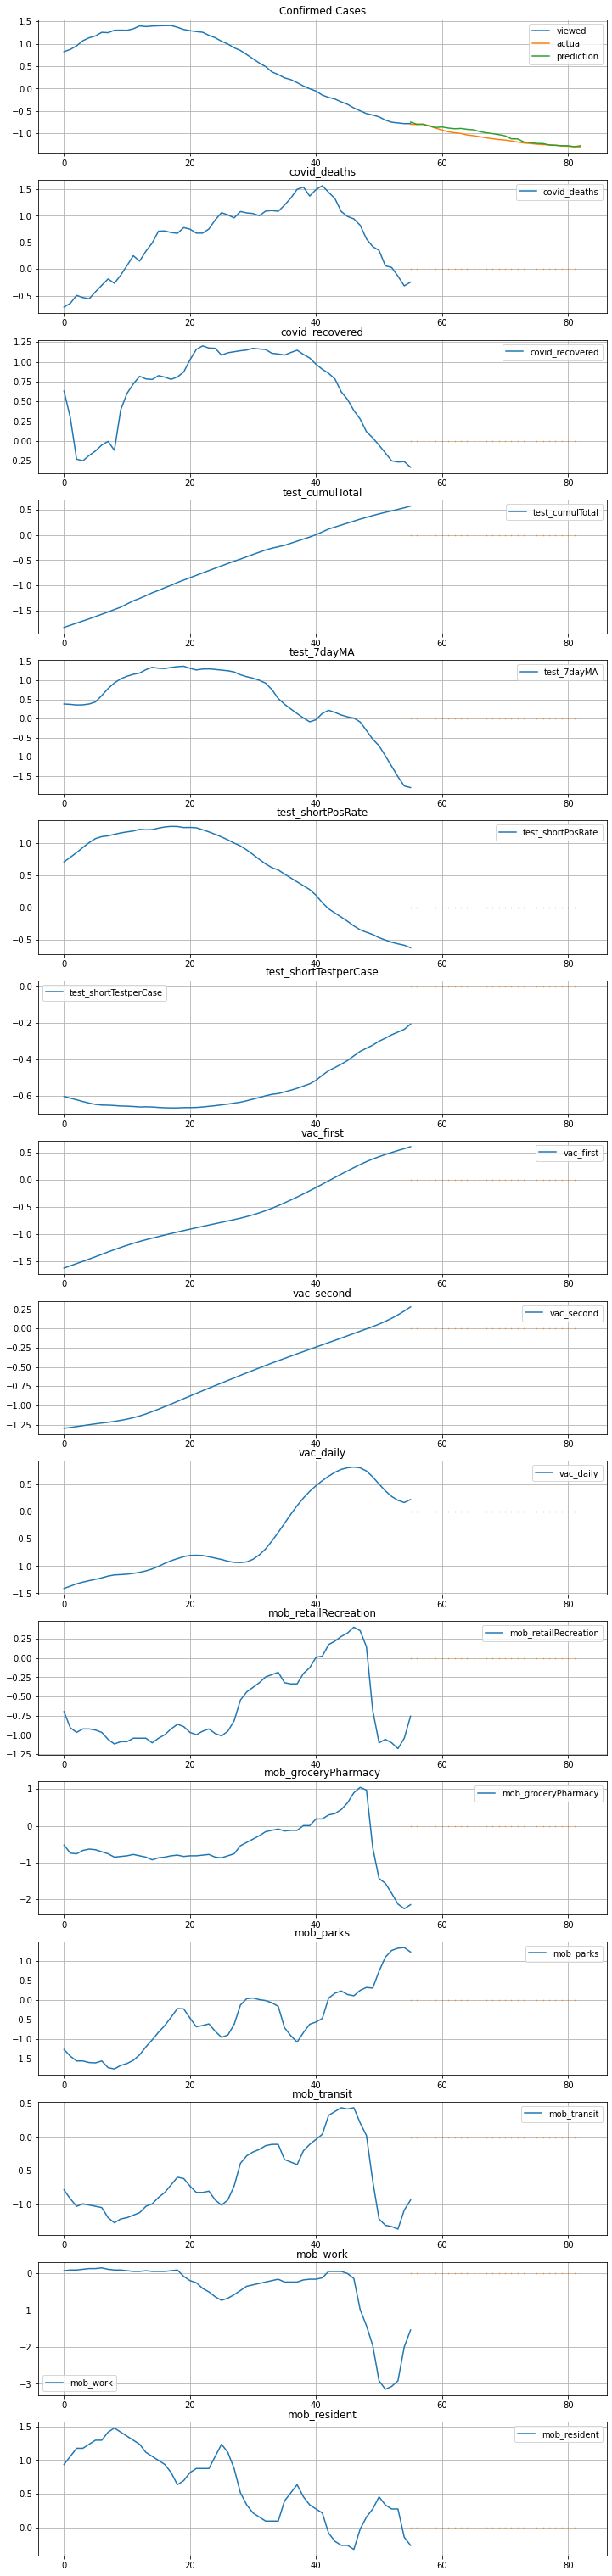

In [105]:
from random import randint
idx = randint(0, len(x_test))
pred = model.predict(x_test[idx].reshape(1, window, 16))

import matplotlib.pyplot as plt

f, axs = plt.subplots(16, 1, figsize=(12, 55))

axs[0].title.set_text('Confirmed Cases')
axs[0].grid()
axs[0].plot(range(0,window), x_test[idx][:,0], label = 'viewed')
axs[0].plot(range(window-1,window+predict-1), y_test[idx], label = 'actual')
axs[0].plot(range(window-1,window+predict-1), pred.reshape(-1, 1), label = 'prediction')
axs[0].legend()

fts = [
    'covid_deaths',
    'covid_recovered',
    'test_cumulTotal',
    'test_7dayMA',
    'test_shortPosRate',
    'test_shortTestperCase',
    'vac_first',
    'vac_second',
    'vac_daily',
    'mob_retailRecreation',
    'mob_groceryPharmacy',
    'mob_parks',
    'mob_transit',
    'mob_work',
    'mob_resident',
]

for ft_idx, ft in enumerate(fts):
    axs[ft_idx+1].title.set_text(fts[ft_idx])
    axs[ft_idx+1].grid()
    axs[ft_idx+1].plot(x_test[idx][:, ft_idx+1], label = fts[ft_idx])
    axs[ft_idx+1].plot(range(window-1,window+predict-1), [0]*28, '.', linewidth=2, markersize=1)
    axs[ft_idx+1].legend()
    
plt.show()